# Analyse the AW shape in CREG025.L75 experiments

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap
from fsspec.implementations.local import LocalFileSystem
fs = LocalFileSystem()

%matplotlib inline

/appli/conda-env/3.6/pangeo/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/appli/conda-env/3.6/pangeo/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from kerchunk.hdf import SingleHdf5ToZarr 
from kerchunk.combine import MultiZarrToZarr

import fsspec
import json
import intake

import dask
import dask_hpcconfig
from distributed import Client
from dask.distributed import Client, LocalCluster


In [3]:
cluster = dask_hpcconfig.cluster("datarmor", **{})
client = Client(cluster)
cluster.scale(jobs=2)

/home1/datawork/ctalandi/conda-env/Jupyter-Dask/lib/python3.11/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


>> Function definition START

In [2]:
def Arc_Bat(ztype='isol1000') :

        locpath='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/GRID/'
        locfile='bathymetry_CREG12_V3.3_CT20180612Larger_ct20190102.nc'
        fieldbat=Dataset(locpath+locfile)
        lon  = np.squeeze(fieldbat.variables['nav_lon'])
        lat  = np.squeeze(fieldbat.variables['nav_lat'])
        My_var = np.squeeze(fieldbat.variables['Bathymetry'])

        spval = 0.
        My_var= np.ma.masked_where(My_var <= spval,My_var)

        if ztype == 'isol1000' :
                vmin=1000. ; vmax=2000.
                contours=[1000.]
                limits=[vmin,vmax]
                myticks=[1000.]
        elif ztype == 'isol1500' :
                vmin=1500. ; vmax=2000.
                contours=[1500.]
                limits=[vmin,vmax]
                myticks=[1500.]
        elif ztype == 'isomonarc' :
                vmin=500. ; vmax=4000.
                contours=[500.,2000.,4000.]
                limits=[vmin,vmax]
                myticks=[500.,2000.,4000.]
        elif ztype == 'isol500' :
                vmin=500. ; vmax=500.
                contours=[500.]
                limits=[vmin,vmax]
                myticks=[500.]
        else:
                vmin=0. ; vmax=8000.
                contours=[100.,500.,1000.,2000.,3000.,3500.,4000.]
                limits=[vmin,vmax]
                myticks=[100.,500.,1000.,2000.,3000.,3500.,4000.]

        #
        #rcParams['text.latex.unicode']=True
        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')
        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])
        pal = plt.cm.get_cmap('binary')
        X,Y = m(lon,lat)

        # contour (optional)
        CS2 = m.contour(X, Y, My_var, linewidths=0.5,levels=contours, colors='black', alpha=1.)
        plt.clabel(CS2, CS2.levels, inline=True, fmt='%.0f', fontsize=3)

        return m, X, Y


In [3]:
def Arc_plot(lon,lat,tab,contours,limits,myticks=None,name=None,zmy_cblab=None,zmy_cmap=None,filename='test.pdf',zvar=None):
        #
# Les 2 lignes suivantes posent un probleme a l'execution lie a LaTex ....
#       rcParams['text.usetex']=True
#       rcParams['text.latex.unicode']=True
        #rcParams['font.family']='serif'

        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')

        if zvar == 'sivolu' or zvar == 'siconc'  or zvar == 'ssh' or zvar == 'socurl' :
                zfontsize=10.
        else:
                zfontsize=6.

        if zvar != 'Bathy' :
                m.drawparallels(np.arange(-90.,91.,5.),labels=[False,False,False,False], size=zfontsize, linewidth=0.3)
                m.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True], size=zfontsize, latmax=90.,linewidth=0.3)
                m.fillcontinents(color='grey',lake_color='white')

        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])

        if zmy_cmap != None :
                pal = zmy_cmap
        else:
                pal = plt.cm.get_cmap('coolwarm')
                #pal = plt.cm.get_cmap('terrain')

        X,Y = m(lon,lat)
        C = m.contourf(X,Y,tab,contours,cmap=pal,norm=norm,extend='both')
        if zvar == 'ssh':
                CS=m.contour(X, Y, tab, linewidths=0.5, levels=npy.arange(limits[0],limits[1],5.), colors='k', alpha=0.4)

        ############################################################################################################
        ############################################################################################################
        moorplot=1
        if moorplot == 1 :
                bx_ARCB={'name':'B'  ,'lon_min':-150.,'lon_max':-150.,'lat_min':78.,'lat_max':78.}
                bx_ARCM={'name':'M1' ,'lon_min': 125.,'lon_max': 125.,'lat_min':78.,'lat_max':78.}
                bx_EURA={'name':'EUR','lon_min':  60.,'lon_max':  60.,'lat_min':85.,'lat_max':85.}

                All_box=[bx_ARCB,bx_EURA]
                for box in All_box:
                        lats = [box['lat_min'],box['lat_max']]
                        lons = [box['lon_min'],box['lon_max']]
                        x,y = m(lons,lats)
                        m.scatter(x,y,3,marker='o', color='r')
                        #m.plot(x,y,linewidth=2, color='g')
        ############################################################################################################
        ############################################################################################################

        # colorbar      
        if myticks is None:
                cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8)
        else:
                if zvar == 'votemper' or zvar == 'vosaline' or zvar == 'sivolu' :
                        cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8,drawedges=True)
                else:
                        cbar = plt.colorbar(C,format='%.0f',orientation='vertical',shrink=0.8,drawedges=True)

                cbar.set_label(zmy_cblab,fontsize=zfontsize)
                cl = plt.getp(cbar.ax, 'ymajorticklabels')
                plt.setp(cl, fontsize=zfontsize)

        plt.title(name,fontsize=zfontsize)

        return

In [4]:
def ArcticZoom_map(zyear,infld,zmy_min=-10,zmy_max=10,CASE=None,zmap='Spectral_r'):
    # Plot the 12 months of a given year 

    fig, axes = plt.subplots(3, 4, figsize=(20,15)) 

    for i, ax in enumerate(axes.flat):
        if i < 9: 
            mm='0'+str(i+1) 
        else : 
            mm=str(i+1)
        infld.isel(time_counter=i).isel(y=slice(300,550),x=slice(200,400)).plot(ax=ax,vmin=zmy_min,vmax=zmy_max,cmap=zmap)   
        #ds_ICE['siconc'].sel(time_counter=str(year)+'-'+mm).isel(y=slice(300,550),x=slice(200,400))[0,:,:].plot.contour(ax=ax,levels=[0.15],colors='g')   
        fieldbat['bathy_meter'].isel(t=0,y=slice(300,550),x=slice(200,400)).plot.contour(ax=ax,levels=[500.,2000.],colors='k',alpha=0.8)
        # The indices in the following are taken in the new framework set by the slices just above
        zbx_SVAL={'name':'SVA','lon_min':125,'lon_max':125,'lat_min':50,'lat_max':50}
        zbx_BANN={'name':'BAN','lon_min':147,'lon_max':147,'lat_min':100,'lat_max':100}
        zbx_AANN={'name':'AAN','lon_min':154,'lon_max':154,'lat_min':125,'lat_max':125}
        zbx_KARA={'name':'KAR','lon_min':155,'lon_max':155,'lat_min':150,'lat_max':150}
        zbx_ULAP={'name':'ULA','lon_min':164,'lon_max':164,'lat_min':178,'lat_max':178}
        zbx_LAPT={'name':'LAP','lon_min':155,'lon_max':155,'lat_min':200,'lat_max':200}
        zbx_BGYR={'name':'LAP','lon_min':10,'lon_max':10,'lat_min':175,'lat_max':175}
        All_box=[zbx_SVAL,zbx_BANN,zbx_AANN,zbx_KARA,zbx_ULAP,zbx_LAPT,zbx_BGYR]
        for box in All_box:
            ax.scatter(box['lon_min'],box['lat_min'],20,marker='o', color='r')

        ax.set_title(CASE+'  month:'+str(zyear)+mm)
    return

>> Function definition END

# CREG025.L75  Grid

In [2]:
GRIDPATH='/home1/scratch/ctalandi/CREG025.L75/CREG025.L75-I/'
ds_grd=xr.open_dataset(GRIDPATH+'CREG025.L75_byte_mask.nc')
ds_grd
tmask2D=ds_grd['tmask'].isel(z=0,t=0)

# CREG025.L75  Bathymetry

In [3]:
locpath='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/GRID/'
locfile='CREG025.L75_domain_cfg.nc'
fieldbat=xr.open_dataset(locpath+locfile)

In [4]:
bx_SVAL={'name':'SVA','lon_min':325,'lon_max':325,'lat_min':350,'lat_max':350,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_BANN={'name':'BAN','lon_min':347,'lon_max':347,'lat_min':400,'lat_max':400,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_AANN={'name':'AAN','lon_min':354,'lon_max':354,'lat_min':425,'lat_max':425,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_KARA={'name':'KAR','lon_min':355,'lon_max':355,'lat_min':450,'lat_max':450,'tmin':-1,'tmax':1,'smin':34.,'smax':35.}
bx_ULAP={'name':'ULA','lon_min':364,'lon_max':364,'lat_min':478,'lat_max':478,'tmin':-1,'tmax':1,'smin':34.,'smax':35.}
bx_LAPT={'name':'LAP','lon_min':355,'lon_max':355,'lat_min':500,'lat_max':500,'tmin':-1,'tmax':1,'smin':34.,'smax':35.}
bx_BGYR={'name':'BFG','lon_min':210,'lon_max':210,'lat_min':496,'lat_max':496,'tmin':-1.,'tmax':1.,'smin':28.,'smax':35.}
bx_GINS={'name':'GIN','lon_min':355,'lon_max':355,'lat_min':310,'lat_max':310,'tmin':-2.,'tmax':2.,'smin':28.,'smax':35.}
bx_MIKE={'name':'MIB','lon_min':356,'lon_max':356,'lat_min':237,'lat_max':237,'tmin':-2.,'tmax':2.,'smin':28.,'smax':35.}

# Time series of net surface flux at mooring location

In [10]:
#CASE1='ERA01NEM405' ; freq='5d'
#CASE2='DFS52NEM405' ; freq='5d'

CASE1='NEMO420SKT' ; freq='1m'
CASE2='NEMO420FIN' ; freq='1m'

In [ ]:
%%time 
loc=[bx_SVAL,bx_BANN,bx_AANN,bx_KARA,bx_ULAP,bx_LAPT,bx_BGYR]
ys=1979 ; ye=1989
lst_years=np.arange(ye-ys+1)+ys
# Read the ERA5 flxT file
DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-'+CASE1+'-MEAN/'+freq+'/'
ds_AW = xr.concat([ xr.open_dataset(f)[['qt']]  \
                   for lyear in lst_years \
                   for f in fs.glob(DATA_PATH+str(lyear)+'/'+'CREG025.L75-'+CASE1+'_y'+str(lyear)+'m??.'+freq+'_flxT.nc')],\
                  dim='time_counter')
ds_AW=ds_AW.chunk({'time_counter':4})
ds_AW=xr.where(tmask2D == 0., np.nan, ds_AW)
#print('ds_AW shape: ',ds_AW)

ds_ICE = xr.concat([ xr.open_dataset(f)[['siconc']]  \
                   for lyear in lst_years \
                   for f in fs.glob(DATA_PATH+str(lyear)+'/'+'CREG025.L75-'+CASE1+'_y'+str(lyear)+'m??.'+freq+'_icemod.nc')],\
                  dim='time_counter')
ds_ICE=ds_ICE.chunk({'time_counter':4})

# Read the DFS5.2 flxT file
DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-'+CASE2+'-MEAN/'+freq+'/'
ds_AW_DF = xr.concat([ xr.open_dataset(f)[['qt']]  \
                   for lyear in lst_years \
                   for f in fs.glob(DATA_PATH+str(lyear)+'/'+'CREG025.L75-'+CASE2+'_y'+str(lyear)+'m??.'+freq+'_flxT.nc')],\
                  dim='time_counter')
ds_AW_DF=ds_AW_DF.chunk({'time_counter':4})
ds_AW_DF=xr.where(tmask2D == 0., np.nan, ds_AW_DF)

# Read the DFS5.2 ice concentration 
ds_ICE_DF = xr.concat([ xr.open_dataset(f)[['siconc']]  \
                   for lyear in lst_years \
                   for f in fs.glob(DATA_PATH+str(lyear)+'/'+'CREG025.L75-'+CASE2+'_y'+str(lyear)+'m??.'+freq+'_icemod.nc')],\
                  dim='time_counter')
ds_ICE_DF=ds_ICE_DF.chunk({'time_counter':4})

my_min=-20 ; my_max=20.
fig, axes = plt.subplots(7, 1, figsize=(20,15)) 

for i, ax in enumerate(axes.flat):
    ds_AW['qt'].isel(y=loc[i]['lat_max'],x=loc[i]['lon_max']).plot(ax=ax,label=CASE1)
    ds_AW_DF['qt'].isel(y=loc[i]['lat_max'],x=loc[i]['lon_max']).plot(ax=ax,label=CASE2)
    if loc[i]['name'] == 'SVA' :
        my_min=-80 ; my_max=20.
    elif loc[i]['name'] == 'BAN' : 
        my_min=-20 ; my_max=5.
    elif loc[i]['name'] == 'BFG' : 
        my_min=-5 ; my_max=5.
    elif loc[i]['name'] == 'ULA' or loc[i]['name'] == 'AAN': 
        my_min=-30 ; my_max=5.
    elif loc[i]['name'] == 'LAP'  or loc[i]['name'] == 'KAR': 
        my_min=-50 ; my_max=5.
        
    ax.set_ylim([my_min,my_max])
    ax.set_title(CASE1+' & '+CASE2+'  Moor: '+loc[i]['name'])
    #ax.set_xticks(ds_AW['time_counter'])
    ax.grid(True)
    ax.legend()

plt.tight_layout()
if True: plt.savefig('./FIGURES/CREG025.L75-'+CASE1+'-'+CASE2+'_Qt_TiSe_Moor_y'+str(ys)+'-'+str(ye)+'.png',dpi=300)

# Assess AW vertical structure in the Eurasian Basin 

In [14]:
#CASE='NEMO420TTT'   ; freq='1m'
#CASE='NEMO420SKT'   ; freq='1m'
#CASE='NEMO420ZMF'   ; freq='1m'
CASE='NEMO420DIN'   ; freq='1m'

zyear=1979
DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-'+CASE+'-MEAN/'+freq+'/'
AW_files = [f for f in fs.glob(DATA_PATH+str(zyear)+'/'+'CREG025.L75-'+CASE+'_y'+str(zyear)+'m??.'+freq+'_gridT.nc')]     
AW_files

['/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-NEMO420DIN-MEAN/1m/1979/CREG025.L75-NEMO420DIN_y1979m01.1m_gridT.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-NEMO420DIN-MEAN/1m/1979/CREG025.L75-NEMO420DIN_y1979m02.1m_gridT.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-NEMO420DIN-MEAN/1m/1979/CREG025.L75-NEMO420DIN_y1979m03.1m_gridT.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-NEMO420DIN-MEAN/1m/1979/CREG025.L75-NEMO420DIN_y1979m04.1m_gridT.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-NEMO420DIN-MEAN/1m/1979/CREG025.L75-NEMO420DIN_y1979m05.1m_gridT.nc',
 '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-NEMO420DIN-MEAN/1m/1979/CREG025.L75-NEMO420DIN_y1979m06.1m_gridT.nc',
 '/home/datawork-lops-drakkarcom/SIMULAT

In [13]:
%%time 
loc=[bx_SVAL,bx_BANN,bx_AANN,bx_KARA,bx_ULAP,bx_LAPT,bx_BGYR]
ys=1979 ; ye=1989
ys=1990 ; ye=1992
lst_years=np.arange(ye-ys+1)+ys
file_ext='z0-500m'


# Read the gridT file
ds_AW = xr.concat([ xr.open_dataset(f)[['votemper','vosaline']]  \
                   for lyear in lst_years \
                   for f in fs.glob(DATA_PATH+str(lyear)+'/'+'CREG025.L75-'+CASE+'_y'+str(lyear)+'m??.'+freq+'_gridT.nc')],\
                  dim='time_counter')
ds_AW=ds_AW.chunk({'time_counter':4})
print('ds_AW shape: ',ds_AW)

# Compute the AWTmax depth
if True: 
    print('compute the AWT max Depth')
    vosaline=ds_AW['vosaline']
    votemper=ds_AW['votemper']
    temp_map, depth_map = awtmax_depth(votemper,vosaline,'deptht',np.array(ds_AW['deptht']),ztime=ds_AW.dims['time_counter'], zmask=tmask2D)
    depth_map=depth_map.assign_coords({'time_counter':ds_AW['time_counter']})
  

fig, axes=plt.subplots(len(loc),1,figsize=(20,15))
for i, ax in enumerate(axes.flat):
    ds_AW['votemper'].sortby('time_counter').isel(y=loc[i]['lat_min'],x=loc[i]['lon_max']).plot(x='time_counter', y='deptht', \
                                                                     vmin=loc[i]['tmin'],vmax=loc[i]['tmax'], \
                                                                     cmap='Spectral_r',
                                                                     ax=ax)
    #CS=ds_AW['votemper'].isel(y=loc[i]['lat_min'],x=loc[i]['lon_max']).plot.contour(x='time_counter', y='deptht', \
    #                                                                       levels=[3.5],colors='k',ax=ax)
    #ax.clabel(CS,fmt='%1.1f',fontsize=8)
    ax.invert_yaxis()  
    ax.set_ylim([500.,0.])    
    #plt.ylim([500.,0.])    
    depth_map.isel(y=loc[i]['lat_min'],x=loc[i]['lon_max']).plot(ax=ax)
    ax.set_title('CREG025.L75-'+CASE+'\n'+'Mooring '+loc[i]['name'])

    if False:
        plt.subplot(212)
        ds_AW['vosaline'].isel(y=loc['lat_min'],x=loc['lon_max']).plot(x='time_counter', y='deptht', \
                                                                               vmin=loc['smin'],vmax=loc['smax'],cmap='Spectral_r')
        CS=ds_AW['vosaline'].isel(y=loc['lat_min'],x=loc['lon_max']).plot.contour(x='time_counter', y='deptht', \
                                                                               levels=[33.5,34.6],colors='k')
        plt.clabel(CS,fmt='%1.1f',fontsize=8)

        plt.gca().invert_yaxis()
        plt.ylim([1000.,0.])
        plt.title('CREG025.L75-'+CASE+'\n'+'Mooring '+loc['name'])

plt.tight_layout()
if False: plt.savefig('./FIGURES/CREG025.L75-'+CASE+'_TS_TiSe_Moor_'+file_ext+'_y'+str(ys)+'-'+str(ye)+'.png',dpi=300)

NameError: name 'DATA_PATH' is not defined

# Perform a difference between 2 experiments 

In [5]:
CASE1='NEMO420SKT'   ; freq='1m'
CASE2='NEMO420DIN'   ; freq='1m'

ds_TTT shape:  <xarray.Dataset>
Dimensions:        (deptht: 75, time_counter: 36, x: 528, y: 603)
Coordinates:
    nav_lat        (y, x) float32 dask.array<shape=(603, 528), chunksize=(603, 528)>
    nav_lon        (y, x) float32 dask.array<shape=(603, 528), chunksize=(603, 528)>
  * deptht         (deptht) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
  * time_counter   (time_counter) object 1979-01-16 12:00:00 ... 1981-12-16 12:00:00
    time_centered  (time_counter) object dask.array<shape=(36,), chunksize=(4,)>
Dimensions without coordinates: x, y
Data variables:
    votemper       (time_counter, deptht, y, x) float32 dask.array<shape=(36, 75, 603, 528), chunksize=(4, 75, 603, 528)>
Attributes:
    name:              /home1/scratch/ctalandi/CREG025.L75-NEMO420SKT-XIOS.1/...
    description:       ocean T grid variables
    title:             ocean T grid variables
    Conventions:       CF-1.6
    timeStamp:         2024-Oct-08 13:22:38 GMT
    uuid:              4385c7c6-2670-

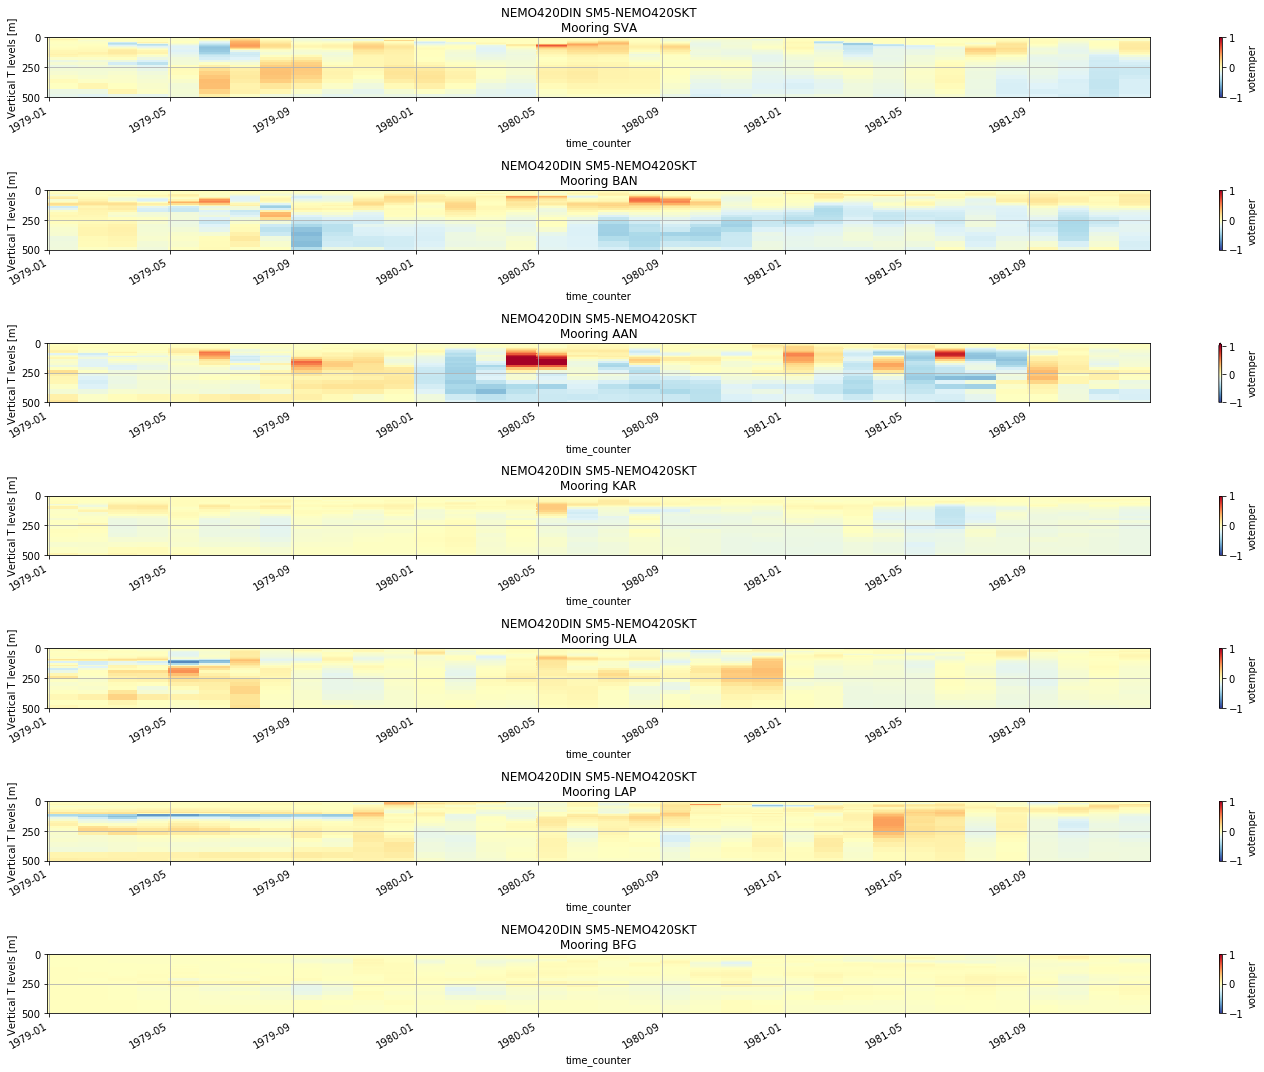

In [10]:
%%time 
loc=[bx_SVAL,bx_BANN,bx_AANN,bx_KARA,bx_ULAP,bx_LAPT,bx_BGYR]
#loc=[bx_MIKE,bx_GINS]

ys=1979 ; ye=1981
#ys=1988 ; ye=1996
#ys=1986 ; ye=1992
lst_years=np.arange(ye-ys+1)+ys
file_ext='z0-500m'

# Read the gridT file
DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-'+CASE1+'-MEAN/'+freq+'/'
ds_TTT = xr.concat([ xr.open_dataset(f)[['votemper']]  \
                   for lyear in lst_years \
                   for f in fs.glob(DATA_PATH+str(lyear)+'/'+'CREG025.L75-'+CASE1+'_y'+str(lyear)+'m??.'+freq+'_gridT.nc')],\
                  dim='time_counter')
ds_TTT=ds_TTT.chunk({'time_counter':4})
print('ds_TTT shape: ',ds_TTT)

DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-'+CASE2+'-MEAN-SM5/'+freq+'/'
ds_SKT = xr.concat([ xr.open_dataset(f)[['votemper']]  \
                   for lyear in lst_years \
                   for f in fs.glob(DATA_PATH+str(lyear)+'/'+'CREG025.L75-'+CASE2+'_y'+str(lyear)+'m??.'+freq+'_gridT.nc')],\
                  dim='time_counter')
ds_SKT=ds_SKT.chunk({'time_counter':4})
print('ds_SKT shape: ',ds_SKT)

new_time_axis=pd.date_range(start=str(ys)+'-01',end=str(ye)+'-12',freq='MS')+ pd.DateOffset(days=14)
ds_SKT = ds_SKT.assign_coords(time_counter=new_time_axis)
ds_TTT = ds_TTT.assign_coords(time_counter=new_time_axis)


fig, axes=plt.subplots(len(loc),1,figsize=(20,15))
for i, ax in enumerate(axes.flat):
    if ys == 1979 and ye == 1981 : 
        lvmin=-1. ; lvmax=1.
    else:
        lvmin=loc[i]['tmin'] ; lvmax=loc[i]['tmax']
    (ds_SKT['votemper'].sortby('time_counter').isel(y=loc[i]['lat_min'],x=loc[i]['lon_max'])- \
     ds_TTT['votemper'].sortby('time_counter').isel(y=loc[i]['lat_min'],x=loc[i]['lon_max'])) \
    .plot(x='time_counter', y='deptht', \
     vmin=lvmin,vmax=lvmax, \
     cmap='RdYlBu_r',
     ax=ax)
    
    ax.invert_yaxis()  
    if file_ext == 'z0-500m' :
        ax.set_ylim([500.,0.])
    else:
        ax.set_ylim([1000.,0.])            
    ax.set_title(CASE2+' SM5'+'-'+CASE1+'\n'+'Mooring '+loc[i]['name'])
    ax.grid(True)
    
plt.tight_layout()
#if True: plt.savefig('./FIGURES/CREG025.L75-'+CASE2+'-'+CASE1+'_TS_TiSe_Moor_'+file_ext+'_y'+str(ys)+'-'+str(ye)+'.png',dpi=300)
if True: plt.savefig('./FIGURES/CREG025.L75-'+CASE2+'_SM5'+'-'+CASE1+'_TS_TiSe_Moor_Adds_'+file_ext+'_y'+str(ys)+'-'+str(ye)+'.png',dpi=300)

>> # Focus on specific moorings 

In [5]:
loc=[bx_LAPT,bx_BGYR]
CASE1='NEMO420JRC'   ; freq='1m'
CASE2='N420REFERA5'   ; freq='1m'

In [6]:
%%time 

if True:
    #ys=1979 ; ye=1987
    ys=1988 ; ye=1994
    #ys=1986 ; ye=1992
    lst_years=np.arange(ye-ys+1)+ys
    file_ext='z0-500m'

    # Read the gridT file
    DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-'+CASE1+'-MEAN/'+freq+'/'
    ds_TTT = xr.concat([ xr.open_dataset(f)[['votemper']]  \
                       for lyear in lst_years \
                       for f in fs.glob(DATA_PATH+str(lyear)+'/'+'CREG025.L75-'+CASE1+'_y'+str(lyear)+'m??.'+freq+'_gridT.nc')],\
                      dim='time_counter')
    ds_TTT=ds_TTT.chunk({'time_counter':4})
    print('ds_TTT shape: ',ds_TTT)

    DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-'+CASE2+'-MEAN/'+freq+'/'
#    DATA_PATH='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/CREG025.L75-'+CASE2+'-MEAN-SM10/'+freq+'/'    
    ds_SKT = xr.concat([ xr.open_dataset(f)[['votemper']]  \
                       for lyear in lst_years \
                       for f in fs.glob(DATA_PATH+str(lyear)+'/'+'CREG025.L75-'+CASE2+'_y'+str(lyear)+'m??.'+freq+'_gridT.nc')],\
                      dim='time_counter')
    ds_SKT=ds_SKT.chunk({'time_counter':4})
    print('ds_SKT shape: ',ds_SKT)

ds_TTT shape:  <xarray.Dataset>
Dimensions:        (deptht: 75, time_counter: 84, x: 528, y: 603)
Coordinates:
  * deptht         (deptht) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
    nav_lon        (time_counter, y, x) float32 dask.array<shape=(84, 603, 528), chunksize=(4, 603, 528)>
    nav_lat        (time_counter, y, x) float32 dask.array<shape=(84, 603, 528), chunksize=(4, 603, 528)>
    time_centered  (time_counter) object dask.array<shape=(84,), chunksize=(4,)>
  * time_counter   (time_counter) object 1988-01-16 12:00:00 ... 1994-12-16 12:00:00
Dimensions without coordinates: x, y
Data variables:
    votemper       (time_counter, deptht, y, x) float32 dask.array<shape=(84, 75, 603, 528), chunksize=(4, 75, 603, 528)>
Attributes:
    name:              /home1/scratch/ctalandi/CREG025.L75-NEMO420JRC-XIOS.10...
    description:       ocean T grid variables
    title:             ocean T grid variables
    Conventions:       CF-1.6
    timeStamp:         2025-Mar-02 16:32:20

In [7]:
new_time_axis=pd.date_range(start=str(ys)+'-01',end=str(ye)+'-12',freq='MS')+ pd.DateOffset(days=14)
ds_SKT = ds_SKT.assign_coords(time_counter=new_time_axis)
ds_TTT = ds_TTT.assign_coords(time_counter=new_time_axis)

CPU times: user 20.6 s, sys: 2min 5s, total: 2min 26s
Wall time: 23.3 s


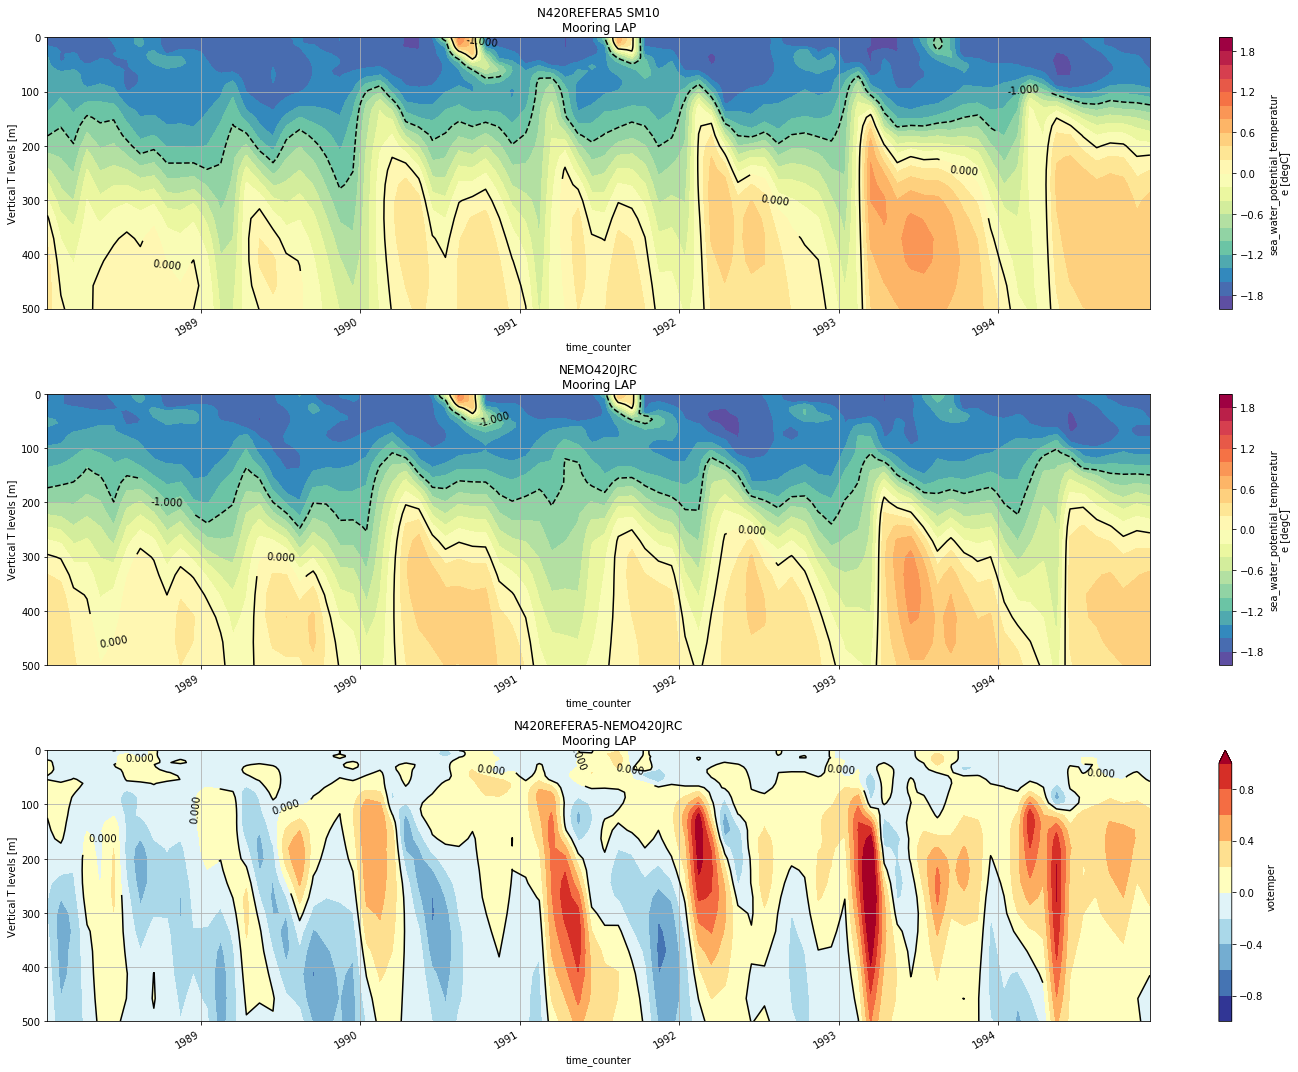

In [8]:
%%time
plt.figure(figsize=(20,15))

i=0 # LAPT 
plt.subplot(311)
C=ds_SKT['votemper'].sortby('time_counter').isel(y=loc[i]['lat_min'],x=loc[i]['lon_max']) \
.plot.contourf(x='time_counter', y='deptht',levels=21,vmin=-2.,vmax=2.,cmap='Spectral_r',yincrease=False)
CS=plt.contour(C,levels=[-1.,0.],colors='k')
plt.clabel(CS,fontsize=10)

plt.ylim([500.,0.])
plt.title(CASE2+'\n'+'Mooring '+loc[i]['name'])
#plt.title(CASE2+' SM10'+'\n'+'Mooring '+loc[i]['name'])
plt.grid(True)

plt.subplot(312)
C=ds_TTT['votemper'].sortby('time_counter').isel(y=loc[i]['lat_min'],x=loc[i]['lon_max']) \
.plot.contourf(x='time_counter', y='deptht',levels=21,vmin=-2.,vmax=2.,cmap='Spectral_r',yincrease=False)
CS=plt.contour(C,levels=[-1.,0.],colors='k')
plt.clabel(CS,fontsize=10)

plt.ylim([500.,0.])
plt.title(CASE1+'\n'+'Mooring '+loc[i]['name'])
plt.grid(True)

plt.subplot(313)
C=(ds_SKT['votemper'].sortby('time_counter').isel(y=loc[i]['lat_min'],x=loc[i]['lon_max'])- \
 ds_TTT['votemper'].sortby('time_counter').isel(y=loc[i]['lat_min'],x=loc[i]['lon_max'])) \
.plot.contourf(x='time_counter', y='deptht',levels=11, vmin=loc[i]['tmin'],vmax=loc[i]['tmax'], cmap='RdYlBu_r',yincrease=False)
CS=plt.contour(C,levels=[-1.,0.],colors='k')
plt.clabel(CS,fontsize=10)

plt.ylim([500.,0.])
plt.title(CASE2+'-'+CASE1+'\n'+'Mooring '+loc[i]['name'])
#plt.title(CASE2+' SM10'+'-'+CASE1+'\n'+'Mooring '+loc[i]['name'])
plt.grid(True)

plt.tight_layout()

if True: plt.savefig('./FIGURES/CREG025.L75-'+CASE2+'-'+CASE1+'_TS_TiSe_Moor_'+loc[i]['name']+'_'+file_ext+'_y'+str(ys)+'-'+str(ye)+'.png',dpi=300)
#if False: plt.savefig('./FIGURES/CREG025.L75-'+CASE2+'_SM10'+'-'+CASE1+'_TS_TiSe_Moor_'+loc[i]['name']+'_'+file_ext+'_y'+str(ys)+'-'+str(ye)+'.png',dpi=300)

CPU times: user 21 s, sys: 2min 13s, total: 2min 34s
Wall time: 24 s


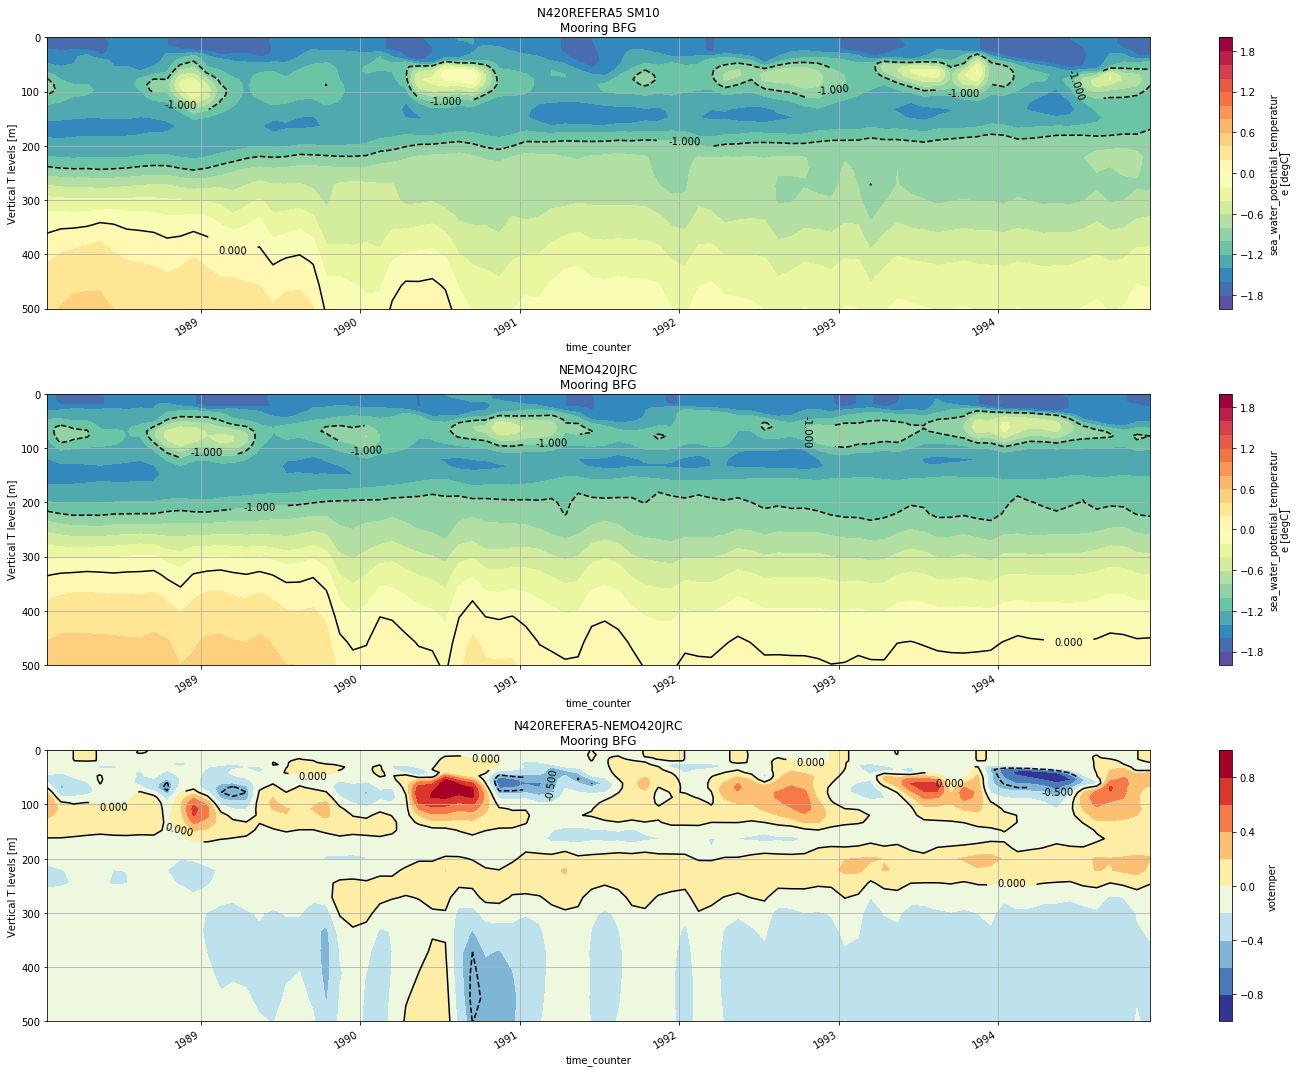

In [9]:
%%time
plt.figure(figsize=(20,15))

i=1 # BFG 
plt.subplot(311)
C=ds_SKT['votemper'].sortby('time_counter').isel(y=loc[i]['lat_min'],x=loc[i]['lon_max']) \
.plot.contourf(x='time_counter', y='deptht',levels=21,vmin=-2.,vmax=2., \
 cmap='Spectral_r',yincrease=False)
CS=plt.contour(C,levels=[-1.,0.],colors='k')
plt.clabel(CS,fontsize=10)

plt.ylim([500.,0.])
plt.title(CASE2+'\n'+'Mooring '+loc[i]['name'])
#plt.title(CASE2+' SM10'+'\n'+'Mooring '+loc[i]['name'])
plt.grid(True)

plt.subplot(312)
C=ds_TTT['votemper'].sortby('time_counter').isel(y=loc[i]['lat_min'],x=loc[i]['lon_max']) \
.plot.contourf(x='time_counter', y='deptht',levels=21,vmin=-2.,vmax=2., \
 cmap='Spectral_r',yincrease=False)
CS=plt.contour(C,levels=[-1.,0.],colors='k')
plt.clabel(CS,fontsize=10)

plt.ylim([500.,0.])
plt.title(CASE1+'\n'+'Mooring '+loc[i]['name'])
plt.grid(True)

plt.subplot(313)
C=(ds_SKT['votemper'].sortby('time_counter').isel(y=loc[i]['lat_min'],x=loc[i]['lon_max'])- \
 ds_TTT['votemper'].sortby('time_counter').isel(y=loc[i]['lat_min'],x=loc[i]['lon_max'])) \
.plot.contourf(x='time_counter', y='deptht',levels=11,vmin=loc[i]['tmin'],vmax=loc[i]['tmax'],cmap='RdYlBu_r',yincrease=False)
CS=plt.contour(C,levels=[-0.5,0.],colors='k')
plt.clabel(CS,fontsize=10)

plt.ylim([500.,0.])
#plt.title(CASE2+' SM10'+'-'+CASE1+'\n'+'Mooring '+loc[i]['name'])
plt.title(CASE2+'-'+CASE1+'\n'+'Mooring '+loc[i]['name'])
plt.grid(True)

plt.tight_layout()

if True: plt.savefig('./FIGURES/CREG025.L75-'+CASE2+'-'+CASE1+'_TS_TiSe_Moor_'+loc[i]['name']+'_'+file_ext+'_y'+str(ys)+'-'+str(ye)+'.png',dpi=300)
#if False: plt.savefig('./FIGURES/CREG025.L75-'+CASE2+'_SM10'+'-'+CASE1+'_TS_TiSe_Moor_'+loc[i]['name']+'_'+file_ext+'_y'+str(ys)+'-'+str(ye)+'.png',dpi=300)

# Plot on a map the mooring location

In [19]:
bx_SVAL={'name':'SVA','lon_min':325,'lon_max':325,'lat_min':350,'lat_max':350,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_BANN={'name':'BAN','lon_min':347,'lon_max':347,'lat_min':400,'lat_max':400,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_AANN={'name':'AAN','lon_min':354,'lon_max':354,'lat_min':425,'lat_max':425,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_KARA={'name':'KAR','lon_min':355,'lon_max':355,'lat_min':450,'lat_max':450,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_ULAP={'name':'ULA','lon_min':364,'lon_max':364,'lat_min':478,'lat_max':478,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_LAPT={'name':'LAP','lon_min':355,'lon_max':355,'lat_min':500,'lat_max':500,'tmin':-2,'tmax':2,'smin':34.,'smax':35.}
bx_BGYR={'name':'BFG','lon_min':200,'lon_max':200,'lat_min':500,'lat_max':500,'tmin':-2.,'tmax':2.,'smin':28.,'smax':35.}
bx_GINS={'name':'GIN','lon_min':355,'lon_max':355,'lat_min':310,'lat_max':310,'tmin':-2.,'tmax':2.,'smin':28.,'smax':35.}
bx_MIKE={'name':'MIB','lon_min':356,'lon_max':356,'lat_min':237,'lat_max':237,'tmin':-2.,'tmax':2.,'smin':28.,'smax':35.}

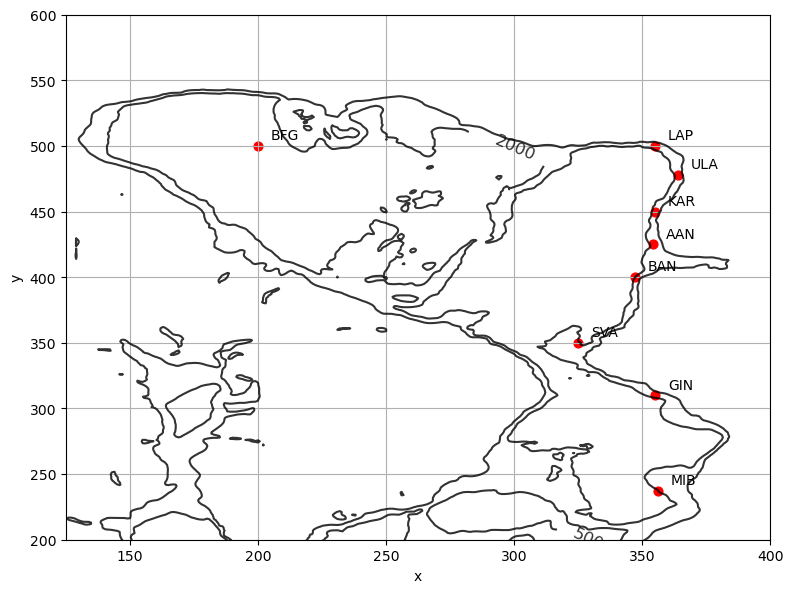

In [20]:
plt.figure(figsize=(20,15))
plt.subplot(221)
CS=fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.8)
plt.clabel(CS,fontsize=12)
plt.ylim([200,600])
plt.xlim([125,400])
All_box=[bx_SVAL,bx_BANN,bx_AANN,bx_KARA,bx_ULAP,bx_LAPT,bx_BGYR,bx_GINS,bx_MIKE]
for box in All_box:
    plt.scatter(box['lon_min'],box['lat_min'],40,marker='o', color='r')
    plt.text(box['lon_min']+5,box['lat_min']+5,box['name'])
plt.grid(True)